### Investigating pinchouts - using unconformity between each lithology

In [1]:
from IPython.display import Image
Image(filename='simple_pinchout_diagram.jpg', width=500)

In [2]:
import numpy as np
import pandas as pd
import numbers

In [3]:
bore_info = pd.read_excel("../Geological_data/Dwer_data\Formation picks.xls",sheet_name = "bore_info2")
strat_info = pd.read_excel("../Geological_data/Dwer_data\Formation picks.xls",sheet_name = "strat_info2")

In [4]:
df = bore_info.copy()
x0, x1, y0, y1, z0, z1 = 0, 4000, 0, 1000, -1000, 200
df = df.drop(['Source'], axis=1)
df = df.drop(['Tr','Tkm', 'Tk','Tkc','Jc','Kcom','Kps','Kpo','Kpc','Kcoh','Kcp','Kcl','Kcg', 'Kcm', 'Kcok','Kwg','Kws'], axis=1)
df = df.reset_index(drop=True)

lithcodes = list(df.columns.values[3:])   # Make a list of formations  
df.Easting = pd.to_numeric(df.Easting)    # Make sure Eastings and Northings are numeric values
df.Northing = pd.to_numeric(df.Northing)
df.Ground = pd.to_numeric(df.Ground)
print(lithcodes)
df

['Ground', 'TQ', 'Kwlp', 'Kwlw', 'Kwlm', 'Jy']


,Easting,Northing,ID,Ground,TQ,Kwlp,Kwlw,Kwlm,Jy
0,1000,500,A,0,-100,-,-,-500,-
1,2000,500,B,0,-100,-200,-400,-500,-
2,3000,500,C,0,-100,-,-,-500,-


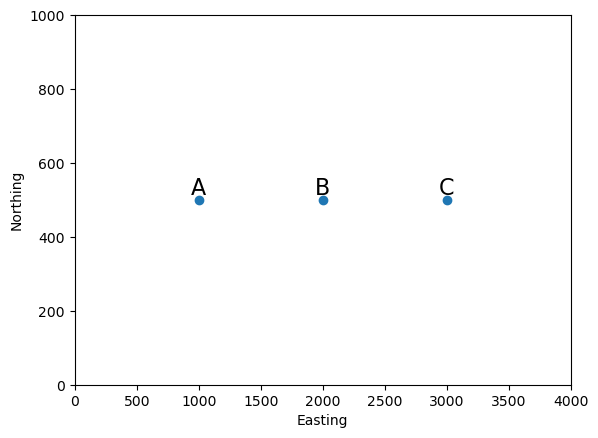

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

figure = True
if figure:
    plt.scatter(df.Easting, df.Northing)
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    i = 0
    for (xi, yi) in zip(df.Easting, df.Northing):
        plt.text(xi, yi, df.ID[i], size = 16, va='bottom', ha='center')
        i += 1
        plt.xlim(x0,x1)
        plt.ylim(y0,y1)

In [6]:
strat = []
for i, lith in enumerate(lithcodes):
    index = i
    lithid = i-1
    val = 100 - i*10 # arbitrary isolvalue
    sequence = strat_info.loc[strat_info['unit'] == lith, 'sequence'].item() 
    R = strat_info.loc[strat_info['unit'] == lith, 'R'].item()/255
    G = strat_info.loc[strat_info['unit'] == lith, 'G'].item()/255
    B = strat_info.loc[strat_info['unit'] == lith, 'B'].item()/255
    strat.append([index, lithid, lith, sequence, val, [round(R,2),round(G,2),round(B,2)]])
strat = pd.DataFrame(strat)
strat.columns =['index','lithid','lithcode','sequences','vals','color']
print('STRATIGRAPHY\n\n')
strat

STRATIGRAPHY




,index,lithid,lithcode,sequences,vals,color
0,0,-1,Ground,Ground,100,"[1.0, 1.0, 1.0]"
1,1,0,TQ,Quaternary,90,"[1.0, 1.0, 0.0]"
2,2,1,Kwlp,Warnbro,80,"[0.8, 1.0, 0.2]"
3,3,2,Kwlw,Warnbro,70,"[0.6, 0.8, 0.0]"
4,4,3,Kwlm,Warnbro,60,"[0.4, 0.6, 0.0]"
5,5,4,Jy,Yarragadee,50,"[0.33, 0.55, 0.83]"


### Make lithology table for Loop

In [33]:
data_list = df.values.tolist()             # Turn data into a list of lists
formatted_data = []

for i in range(len(data_list)): #iterate for each row
    
    boreid = data_list[i][2]
    easting, northing = data_list[i][0], data_list[i][1]
    groundlevel = data_list[i][3]    
           
    # Add data for groundlevel
    val = strat.vals[0]
    gx, gy, gz = 0,0,1
    formatted_data.append([boreid, easting, northing, groundlevel, val, 'Ground', 'Ground_seq', gx, gy, gz]) 

    # Add data row for each lithology
    count = 1
    for j in range(4,df.shape[1]-1): #iterate through each formation 
        
        # Add lithology
        if isinstance(data_list[i][j], numbers.Number) == True:    
            bottom    = groundlevel + float(data_list[i][j])  # Ground surface - formation bottom (mbgl)
            val       = strat.vals[count]                      # designated isovalue
            lithid    = lithcodes[count]                       # lithology id 
            feat_name = str(lithid + '_seq')                   # sequence name
            gx, gy, gz = 0,0,1
            formatted_data.append([boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz])    
            current_bottom = np.copy(bottom)
    
        # For absent units, put in a dummy point in    
        else:
            lithid    = lithcodes[count]                       # lithology id 
            print(lithid, ' is absent in ',boreid)
            
            if lithid == 'Kwlp': # Pinch UP!
                bottom    = current_bottom  + 50
            
            if lithid == 'Kwlw': # Pinch DOWN
                bot_underlying = groundlevel + float(data_list[i][j+1]) # Find bottom of underlying unit
                bottom    = bot_underlying - 50
            
            val       = strat.vals[count]                      # designated isovalue
            feat_name = str(lithid + '_seq')                   # sequence name                 
            gx, gy, gz = 0,0,1
            formatted_data.append([boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz])
            
        count+=1
        
data = pd.DataFrame(formatted_data)
data.columns =['ID','X','Y','Z','val','lithcode','feature_name', 'gx', 'gy', 'gz']

sequences = data['feature_name'].unique()
data

Kwlp  is absent in  A
Kwlw  is absent in  A
Kwlp  is absent in  C
Kwlw  is absent in  C


,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz
0,A,1000,500,0.0,100,Ground,Ground_seq,0,0,1
1,A,1000,500,-100.0,90,TQ,TQ_seq,0,0,1
2,A,1000,500,-50.0,80,Kwlp,Kwlp_seq,0,0,1
3,A,1000,500,-550.0,70,Kwlw,Kwlw_seq,0,0,1
4,A,1000,500,-500.0,60,Kwlm,Kwlm_seq,0,0,1
5,B,2000,500,0.0,100,Ground,Ground_seq,0,0,1
6,B,2000,500,-100.0,90,TQ,TQ_seq,0,0,1
7,B,2000,500,-200.0,80,Kwlp,Kwlp_seq,0,0,1
8,B,2000,500,-400.0,70,Kwlw,Kwlw_seq,0,0,1
9,B,2000,500,-500.0,60,Kwlm,Kwlm_seq,0,0,1


In [34]:
for lith in lithcodes:
    filtered_df = data[data.lithcode == lith] 
    #print('\n')
    #print(filtered_df)
    #print(filtered_df.to_string(index=False))

### Create Geomodel

In [35]:
from LoopStructural import GeologicalModel
origin  = (x0, y0, z0)
maximum = (x1, y1, z1)
geomodel = GeologicalModel(origin, maximum)
geomodel.data = data

### Add surfaces

In [36]:
for i, lith in enumerate(lithcodes):
    print(i, lith)

0 Ground
1 TQ
2 Kwlp
3 Kwlw
4 Kwlm
5 Jy


In [37]:
Ground     = geomodel.create_and_add_foliation("Ground_seq")
GroundUC   = geomodel.add_unconformity(Ground, 100) # Clips above
TQ         = geomodel.create_and_add_foliation("TQ_seq")
TQUC       = geomodel.add_unconformity(TQ, 90) # Clips above
Kwlp         = geomodel.create_and_add_foliation("Kwlp_seq")
KwlpUC       = geomodel.add_unconformity(Kwlp, 80) # Clips above
Kwlw         = geomodel.create_and_add_foliation("Kwlw_seq")
KwlwUC       = geomodel.add_unconformity(Kwlw, 70) # Clips above
Kwlm         = geomodel.create_and_add_foliation("Kwlm_seq")
KwlmUC       = geomodel.add_unconformity(Kwlm, 60) # Clips above

In [38]:
geomodel.feature_name_index

{'Ground_seq': 0,
 'Ground_seq_unconformity': 1,
 'TQ_seq': 2,
 'TQ_seq_unconformity': 3,
 'Kwlp_seq': 4,
 'Kwlp_seq_unconformity': 5,
 'Kwlw_seq': 6,
 'Kwlw_seq_unconformity': 7,
 'Kwlm_seq': 8,
 'Kwlm_seq_unconformity': 9}

### Add Stratigraphy Column

In [39]:
for i in range(len(lithcodes)):
    #stratigraphic_column[str(lithcodes[i] + '_seq')] = {}
    print(lithcodes[i])

Ground
TQ
Kwlp
Kwlw
Kwlm
Jy


In [40]:
stratigraphic_column = {}

for i in range(len(lithcodes)):
    stratigraphic_column[str(lithcodes[i] + '_seq')] = {}
    sequence = str(lithcodes[i] + '_seq')
    lith     = strat.iloc[i].lithcode
    lithid   = strat.iloc[i].lithid
    color    = strat.iloc[i].color  

    if i == 0: # Top unit
        minval   = strat.iloc[i].vals
        stratigraphic_column[sequence][lith] = {'min':minval,'max':np.inf,'id':lithid, 'colour':color} 

    if i > 0 and i < len(lithcodes)-1 : # middle units
        minval   = strat.iloc[i].vals
        maxval   = strat.iloc[i-1].vals
        stratigraphic_column[sequence][lith] = {'min':minval,'max':maxval,'id':lithid, 'colour':color}

    if i == len(lithcodes)-1: # Bottom unit
        maxval   = strat.iloc[i-1].vals
        stratigraphic_column[sequence][lith] = {'min':-np.inf,'max':maxval,'id':lithid,  'colour':color}   

geomodel.set_stratigraphic_column(stratigraphic_column)
stratigraphic_column

{'Ground_seq': {'Ground': {'min': 100,
   'max': inf,
   'id': -1,
   'colour': [1.0, 1.0, 1.0]}},
 'TQ_seq': {'TQ': {'min': 90, 'max': 100, 'id': 0, 'colour': [1.0, 1.0, 0.0]}},
 'Kwlp_seq': {'Kwlp': {'min': 80,
   'max': 90,
   'id': 1,
   'colour': [0.8, 1.0, 0.2]}},
 'Kwlw_seq': {'Kwlw': {'min': 70,
   'max': 80,
   'id': 2,
   'colour': [0.6, 0.8, 0.0]}},
 'Kwlm_seq': {'Kwlm': {'min': 60,
   'max': 70,
   'id': 3,
   'colour': [0.4, 0.6, 0.0]}},
 'Jy_seq': {'Jy': {'min': -inf,
   'max': 60,
   'id': 4,
   'colour': [0.33, 0.55, 0.83]}}}

### 3D View

In [41]:
from LoopStructural.visualisation import LavaVuModelViewer
viewer =  LavaVuModelViewer(geomodel)
viewer.add_model_surfaces(faults = False, cmap = 'Spectral')
#viewer.add_points(points = np.array(well_tops), name = 'fault')
viewer.set_zscale(zscale = 2)
viewer.interactive()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

### 2D View

In [31]:
sequences

array(['Ground_seq', 'TQ_seq', 'Kwlp_seq', 'Kwlw_seq', 'Kwlm_seq',
       'Jy_seq'], dtype=object)

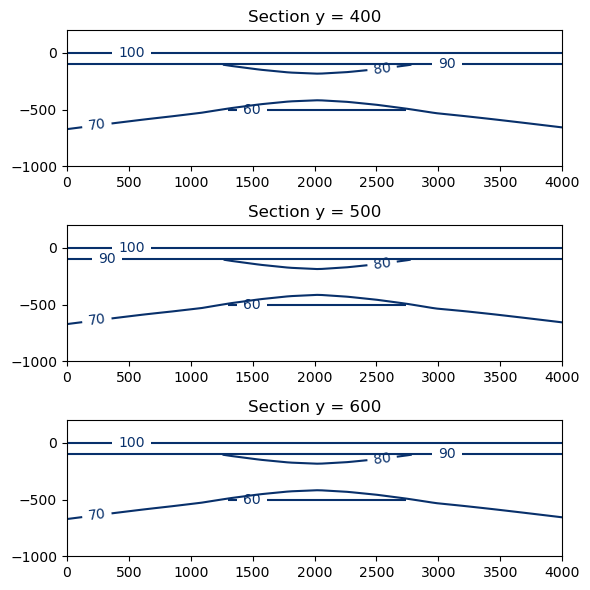

In [42]:
y_transects = [400,500,600]

fig, ax = plt.subplots(3,1,figsize=(6,6))

delx, delz = 100, 100
x, z = np.linspace(x0,x1,delx), np.linspace(z0,z1,delz)
xx, zz = np.meshgrid(x,z)
yy = np.zeros_like(xx)

for j in range(3):

    yy[:] = y_transects[j]
    ax[j].set_title('Section y = %i' %y_transects[j])

    for i, seq in enumerate(sequences):
        levels = [-999, strat.vals[i]]
        vals = geomodel.evaluate_feature_value(seq, np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T)
        con = ax[j].contour(vals.reshape((delz, delx)), levels = levels, extent=(x0, x1, z0, z1), cmap = 'Blues')
        ax[j].clabel(con, inline=True, fontsize=10)
    
plt.tight_layout() 
plt.show()